**Este notebook foi utilizado exclusivamente para análise do conjunto de dados e entendimento do negócio. Construção de novas Features e Funções que serão utilizadas na sequencia do desenvolvimento do projeto.**



# 0.0. Imports

In [132]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import datetime   as dt

import inflection
import pickle

from plotly           import express  as px
from matplotlib       import pyplot   as plt
from pandas_profiling import ProfileReport

from IPython.display import HTML

## 0.1. Helper Function

In [133]:
def get_month(x): 
    return dt.datetime(x.year, x.month, 1) 


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [136]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda/envs/manfing/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda/envs/manfing/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## 0.2 Load dataset

In [137]:
df_raw = pd.read_excel( '../data/raw/DataSet_Test.xlsx', usecols="A:G")

# 1.0. Data Description

In [138]:
df1 = df_raw.copy()

In [139]:
df1.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 1.1. Rename Columns

In [140]:
cols_old = ['BillNo', 'ItemName', 'Quantity', 'Date', 'Price', 'CustomerID', 'Country']

# change columns names to snakecase format
snakecase = lambda x: inflection.underscore( x )
cols_news = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_news
df1.columns

Index(['bill_no', 'item_name', 'quantity', 'date', 'price', 'customer_id',
       'country'],
      dtype='object')

## 1.2. Data Dimensions

In [141]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )

Number of Rows: 522064
Number of Columns: 7


## 1.3. Data Types

In [142]:
df1.dtypes

bill_no                object
item_name              object
quantity                int64
date           datetime64[ns]
price                 float64
customer_id           float64
country                object
dtype: object

## 1.4. Check NA

In [143]:
df1.isna().sum()

bill_no             0
item_name        1455
quantity            0
date                0
price               0
customer_id    134041
country             0
dtype: int64

## 1.5. Replace NA

In [144]:
df1 = df1.dropna(subset=['item_name','customer_id'])
print( f'Removed data : { 1-( df1.shape[0] / df_raw.shape[0]):.2f} %')

Removed data : 0.26 %


In [145]:
df1.isna().sum()

bill_no        0
item_name      0
quantity       0
date           0
price          0
customer_id    0
country        0
dtype: int64

## 1.6. Change Types

In [146]:
df1.dtypes

bill_no                object
item_name              object
quantity                int64
date           datetime64[ns]
price                 float64
customer_id           float64
country                object
dtype: object

In [147]:
# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)
# bill_no
df1['bill_no'] = df1['bill_no'].astype(int)

In [148]:
df1.dtypes

bill_no                 int64
item_name              object
quantity                int64
date           datetime64[ns]
price                 float64
customer_id             int64
country                object
dtype: object

## 1.7.  Descriptive Statistic

In [149]:
# splitting numerical and categorical attributes
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [150]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,bill_no,536365.0,581587.00,45222.00,560610.618886,561888.00,13127.750045,-0.177985,-1.203868
1,quantity,1.0,80995.00,80994.00,12.892140,5.00,182.605082,398.939104,170018.533836
2,price,0.0,8142.75,8142.75,3.079258,1.95,21.984541,210.091777,60679.390432
3,customer_id,12346.0,18287.00,5941.00,15316.931710,15265.00,1721.844746,0.006838,-1.207273


## 1.8. Categorical Attributes

In [151]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

item_name    3846
country        29
dtype: int64

### 1.8.1 Country

In [152]:
df1['country'].value_counts( normalize=True ).head(10)

United Kingdom    0.913206
Germany           0.023303
France            0.021499
Spain             0.006404
Netherlands       0.006090
Belgium           0.005234
Switzerland       0.004747
Portugal          0.003768
Australia         0.003054
Norway            0.002763
Name: country, dtype: float64

In [153]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country').count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
27,United Kingdom,3921
6,Germany,94
5,France,87
22,Spain,30
3,Belgium,25


## Notes

- Preço unitário igual a zero

# 2.0. Filtragem de Variáveis 

In [215]:
df2 = df1.copy()
df2.head()

,bill_no,item_name,quantity,date,price,customer_id,country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [216]:
## == Numerical attributtes
df2 = df2.loc[df2['price'] >= 0.04,:]

df2 = df2[~df2["item_name"].str.contains("POST", na=False)]

# country
#df2 = df2[df2.country == "United Kingdom"]
df2 = df2[~df2['country'].isin( ["Unspecified"] )]

# bad users
#df2 = df2[~df2['customer_id'].isin( [16446] )]

# description
#df2 = df2.drop(columns='item_name', axis=1)

## Notes

- Foi removido valores zero

- Foi removido item_name = POSTAGE

- Foi removido country = Unspecified

- customer_id = 16446 -> Possivel Otlier

# 3.0. Feature Engineering

In [236]:
df3 = df2.copy()

## 3.1. Feature Creation

In [237]:
# removendo hora
df3['date'] = df3['date'].apply( get_month )
# month
df3['month'] = df3['date'].dt.month

In [238]:
# data product_id -> criando codigo unico para os produtos.
df_product_id = df3.drop( ['bill_no', 'quantity', 'date', 'price','customer_id', 'country', 'month'], axis=1 ).drop_duplicates( ignore_index=True)
df_product_id = pd.DataFrame( df_product_id ) 
df_product_id['produto_id'] = pd.factorize( df_product_id['item_name'])[0]

# merge produto_id com df3
df3 = pd.merge( df3, df_product_id, on='item_name', how='left' )
df3.isna().sum()

bill_no        0
item_name      0
quantity       0
date           0
price          0
customer_id    0
country        0
month          0
produto_id     0
dtype: int64

In [239]:
df3.head()

,bill_no,item_name,quantity,date,price,customer_id,country,month,produto_id
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,12,0
1,536365,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,12,1
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,12,2
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,12,3
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,12,4


 - **PRODUTO_ID:** Feature criada para auxiliar na criação de novas colunas Ex: Quantidade de produto po customer. 
 - produto_id vai ser Utilizada no sistema de recomendação.

### 3.1.1 Creation data REF

In [240]:
# data refence
df_ref = df3.drop( ['bill_no','item_name', 'quantity','date', 'price', 'country', 'produto_id', 'month'], axis=1 ).drop_duplicates( ignore_index=True)

### 3.1.2 Monetary / Recency /Frequency

In [241]:
# Gross Revenue ( Faturamento ) quantity * price
df3.loc[:, 'monetary'] = df3.loc[:, 'quantity'] * df3.loc[:, 'price']

# Monetary
df_monetary = df3.loc[:,[ 'customer_id', 'monetary']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

## Recency - Last day purchase
df_recency = df3.loc[:, ['customer_id', 'date']].groupby( 'customer_id' ).max().reset_index()

df_recency['recency'] = ( df3['date'].max() - df_recency['date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = (df3.loc[:, ['customer_id', 'bill_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'bill_no': 'frequency'}) )
# Merge
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

### 3.1.2 Quantidade de Items

In [242]:
df_freq = (df3.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
# Merge           
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

### 3.1.3 Quantidade de Produtos

In [243]:
df_freq = (df3.loc[:, ['customer_id', 'produto_id']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'produto_id': 'qtde_products'} ) )
# Merge 
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

### 3.1.4 Average Ticket Value

In [244]:
df_avg_ticket = df3.loc[:,['customer_id', 'monetary']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'monetary':'avg_ticket'} )

# Merge    
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

### 3.1.5 Basket Size - Quantidade de item por Cesta

In [245]:
 df_aux = ( df3.loc[:, ['customer_id', 'bill_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'bill_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id        0
monetary           0
recency            0
frequency          0
qtde_items         0
qtde_products      0
avg_ticket         0
avg_basket_size    0
dtype: int64

In [246]:
df_ref.head()

,customer_id,monetary,recency,frequency,qtde_items,qtde_products,avg_ticket,avg_basket_size
0,17850,5391.21,365,34,1733,297,18.152222,50.970588
1,13047,3222.24,30,10,1385,171,18.843509,138.500000
2,12583,6705.38,0,15,5028,232,28.902500,335.200000
3,13748,948.25,91,5,439,28,33.866071,87.800000
4,15100,876.00,334,3,80,3,292.000000,26.666667


In [247]:
df3.head()

,bill_no,item_name,quantity,date,price,customer_id,country,month,produto_id,monetary
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,12,0,15.30
1,536365,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,12,1,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,12,2,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,12,3,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,12,4,20.34


## Notes

- Nesta seção foi criado feature **produto_id** no df3 sera realizado sistema de recomendação com esse dataframe

- Foi criado **df_ref** para análise de comportamento dos customer -> sera realizado clustering

# 4.0. Análise Exploratória dos Dados

In [248]:
df4 = df_ref.copy()

## 4.1. Univariate Analysis

### 4.1.1 Gross Revenue

In [249]:
df4.sort_values( 'monetary', ascending=False ).head()

,customer_id,monetary,recency,frequency,qtde_items,qtde_products,avg_ticket,avg_basket_size
840,14646,279025.70,0,72,196556,2058,135.581001,2729.944444
419,18102,259129.60,0,60,64114,430,602.626977,1068.566667
372,17450,194550.79,0,46,69993,337,577.302047,1521.586957
2578,16446,168472.50,0,2,80997,3,56157.500000,40498.500000
908,12415,124496.53,30,20,77173,712,174.854677,3858.650000


In [270]:
 df3[df3['customer_id'] == 14646].head(10)

,bill_no,item_name,quantity,date,price,customer_id,country,month,produto_id,monetary
23953,539491,PACK OF 12 WOODLAND TISSUES,12,2010-12-01,0.29,14646,Netherlands,12,695,3.48
23954,539491,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-01,0.29,14646,Netherlands,12,406,3.48
23955,539491,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-01,4.95,14646,Netherlands,12,2130,9.90
23956,539491,JUMBO STORAGE BAG SUKI,1,2010-12-01,1.95,14646,Netherlands,12,75,1.95
23957,539491,PACK OF 20 SPACEBOY NAPKINS,2,2010-12-01,0.85,14646,Netherlands,12,1823,1.70
23958,539491,FUNKY WASHING UP GLOVES ASSORTED,1,2010-12-01,2.10,14646,Netherlands,12,1241,2.10
23959,539491,RED RETROSPOT BIG BOWL,2,2010-12-01,4.95,14646,Netherlands,12,1880,9.90
23960,539491,JAM MAKING SET WITH JARS,1,2010-12-01,4.25,14646,Netherlands,12,21,4.25
23961,539491,CHARLOTTE BAG SUKI DESIGN,2,2010-12-01,0.85,14646,Netherlands,12,879,1.70
23962,539491,SET/10 IVORY POLKADOT PARTY CANDLES,2,2010-12-01,1.25,14646,Netherlands,12,586,2.50


### 4.1.2 Qtd Items

In [251]:
df4[df4['qtde_items'] >= 80000].head()

,customer_id,monetary,recency,frequency,qtde_items,qtde_products,avg_ticket,avg_basket_size
840,14646,279025.7,0,72,196556,2058,135.581001,2729.944444
2578,16446,168472.5,0,2,80997,3,56157.500000,40498.500000


 ### 4.1.3. Qtde Products

In [265]:
#df4.sort_values( 'qtde_products', ascending=False ).head(10)

df4[df4['customer_id'] == 17841].head()

,customer_id,monetary,recency,frequency,qtde_items,qtde_products,avg_ticket,avg_basket_size
68,17841,40820.72,0,124,23024,7822,5.218706,185.677419


In [268]:
#df4[df4['avg_ticket'] == 56157.5]
df3[df3['customer_id'] == 16446]

,bill_no,item_name,quantity,date,price,customer_id,country,month,produto_id,monetary
130227,553573,PANTRY SCRUBBING BRUSH,1,2011-05-01,1.65,16446,United Kingdom,5,2689,1.65
130228,553573,PANTRY PASTRY BRUSH,1,2011-05-01,1.25,16446,United Kingdom,5,2770,1.25
385663,581483,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-01,2.08,16446,United Kingdom,12,3833,168469.60


### 4.1.5 Frequency

In [254]:
df4[df4['frequency'] > 90]
#df3[df3['customer_id'] == 17850]

,customer_id,monetary,recency,frequency,qtde_items,qtde_products,avg_ticket,avg_basket_size
8,15311,60760.10,0,91,38190,2378,25.550925,419.670330
46,12748,33562.33,0,209,25144,4587,7.316837,120.306220
68,17841,40820.72,0,124,23024,7822,5.218706,185.677419
89,14606,12026.90,0,92,6211,2696,4.461016,67.510870
234,13089,58727.33,0,97,31000,1814,32.374493,319.587629


### 4.1.6 Average Basket Size

In [255]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,monetary,recency,frequency,qtde_items,qtde_products,avg_ticket,avg_basket_size
2578,16446,168472.5,0,2,80997,3,56157.5,40498.5


## Notes

- Customer 16446 -> Possivel Outlier  Total de compras: 3 / Qtd de produto: 80997 / Gross Revenue: 168469.60	

## 4.2. Bivariate Analysis

### 4.2.1  TOP 50 Produto mais vendido

In [256]:
aux = df3[['item_name', 'quantity']].groupby('item_name').sum().reset_index()
aux = aux.sort_values( 'quantity', ascending=False).head(50)

fig = px.treemap( aux, path=['item_name'], values='quantity')
fig.show()

/opt/anaconda/envs/manfing/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda/envs/manfing/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### 4.2.2 TOP 20 ID mais vendido

<AxesSubplot:xlabel='produto_id', ylabel='quantity'>

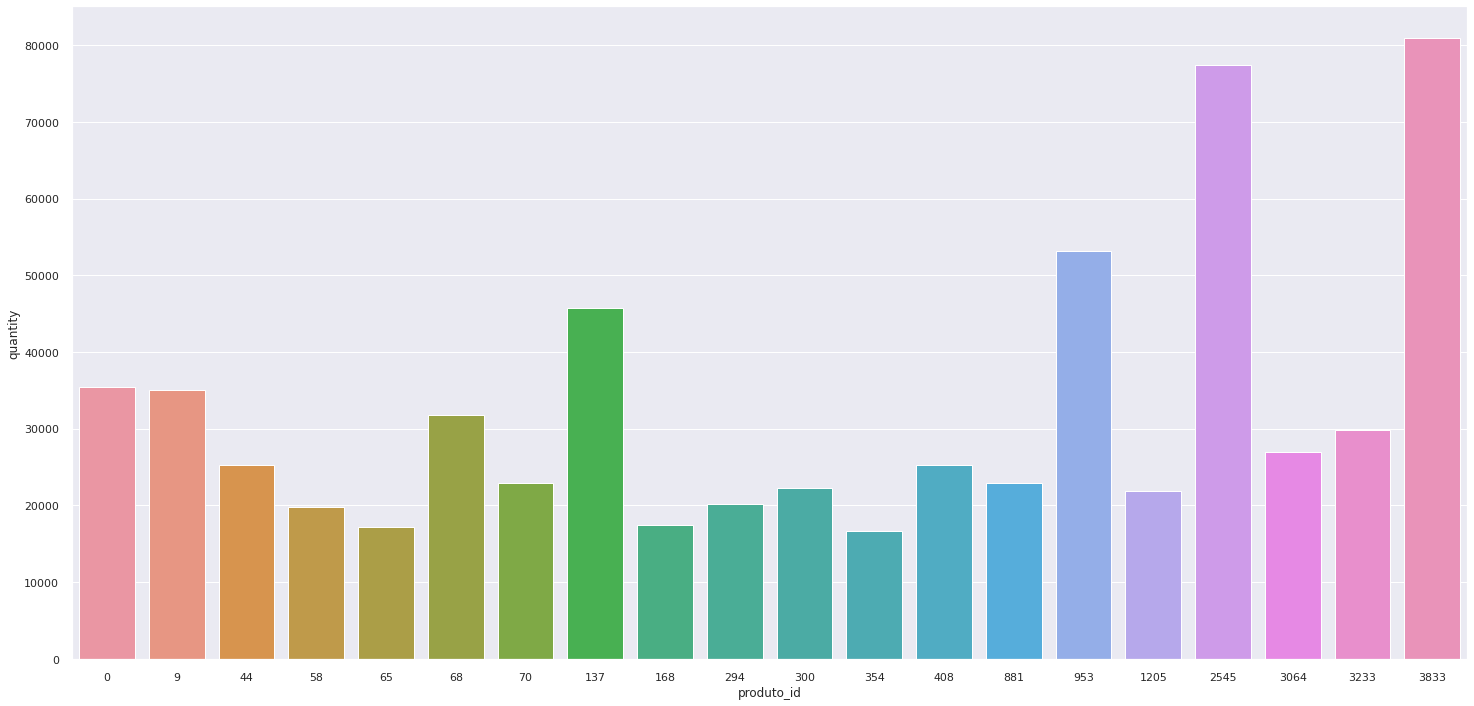

In [257]:
aux = df3[['produto_id', 'quantity']].groupby('produto_id').sum().reset_index()
aux = aux.sort_values( 'quantity', ascending=False).head(20)
sns.barplot( x='produto_id', y='quantity', data=aux)

### 4.2.3 Gross Month

<AxesSubplot:xlabel='month', ylabel='monetary'>

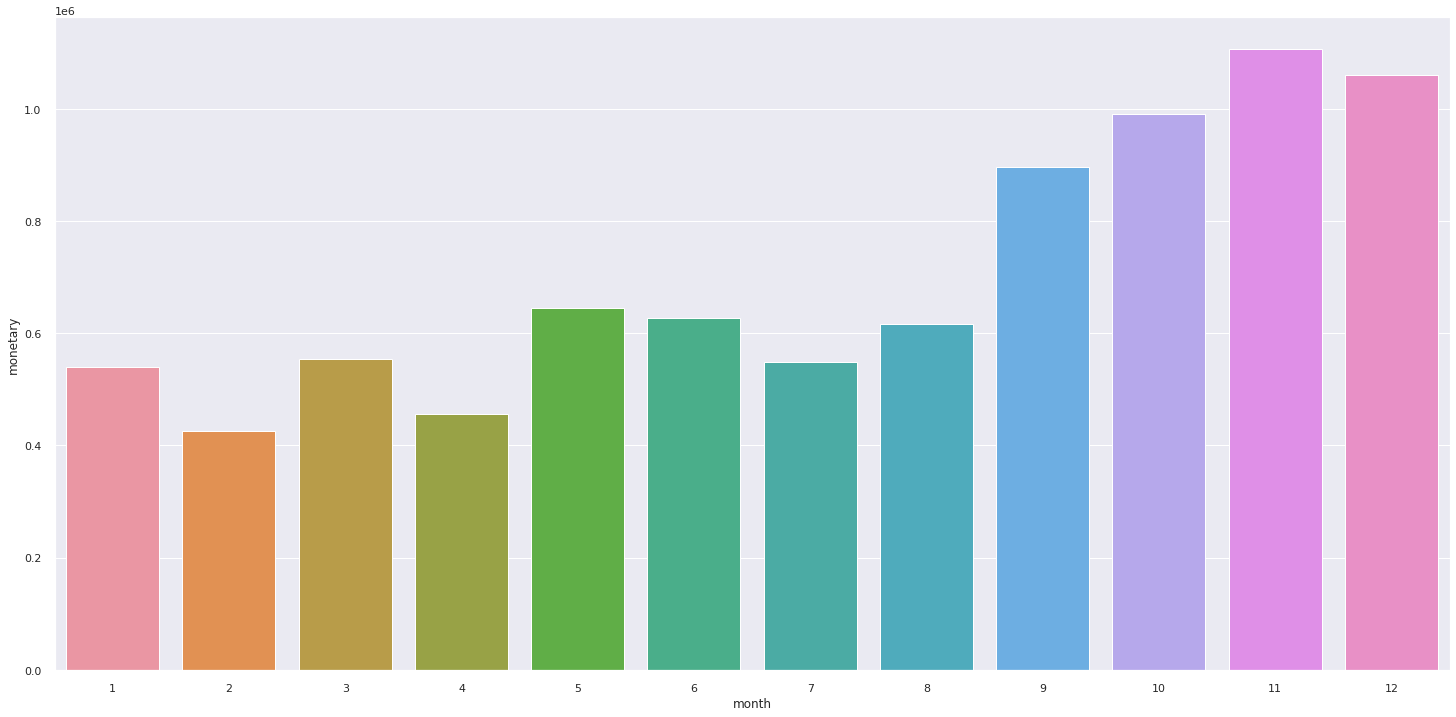

In [258]:
aux = df3[['date', 'month', 'monetary']].groupby( 'month' ).sum().reset_index()
sns.barplot( x='month', y='monetary', data=aux)

# 4.2.4 bill_no por Country

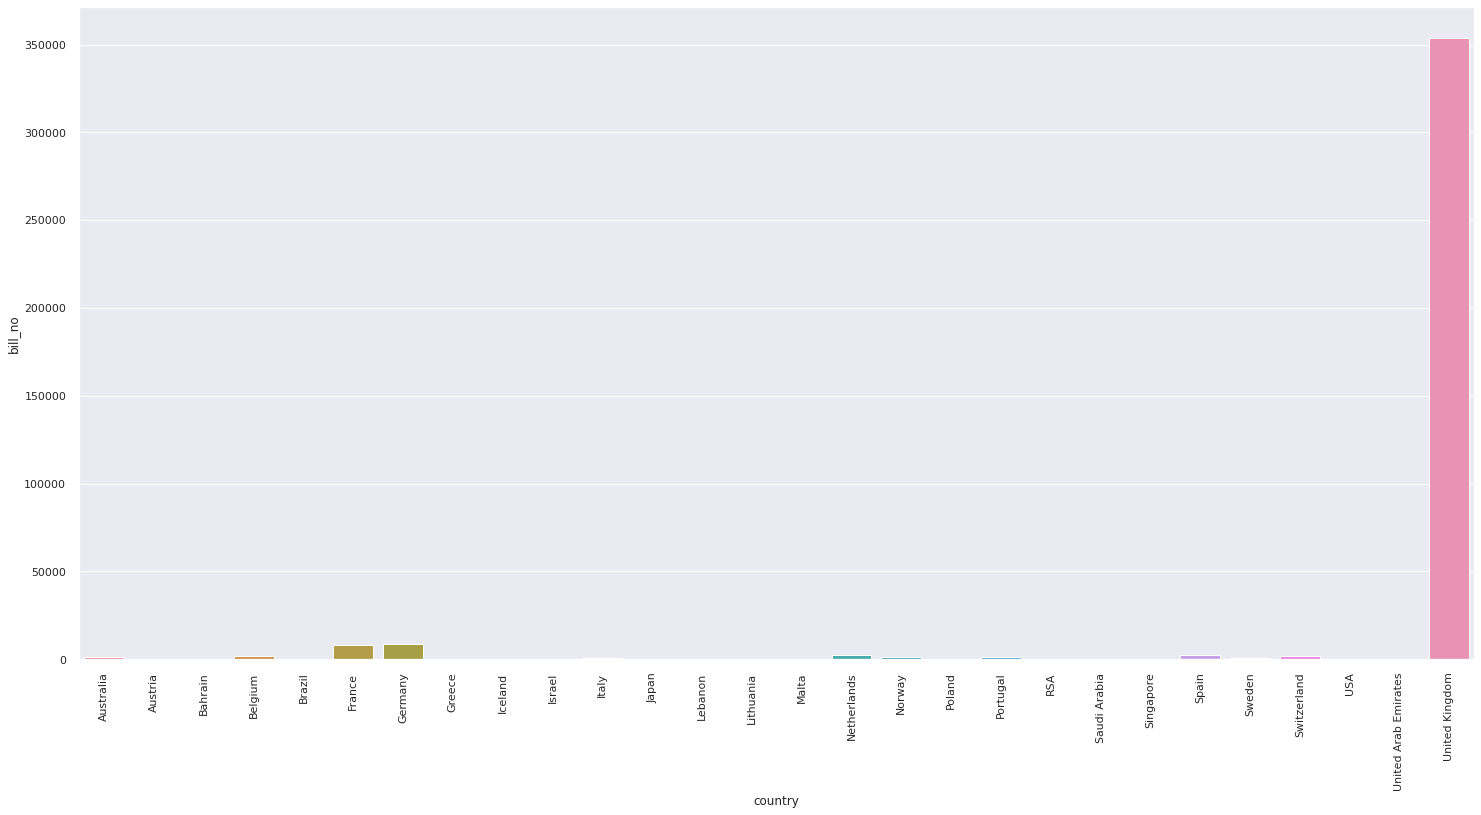

In [259]:
aux = df3[['bill_no', 'country']].groupby( 'country' ).count().reset_index()
sns.barplot( x='country', y='bill_no', data=aux)
plt.xticks(rotation=90);

## Notes

- Desbalanceamento no conjunto de dados United Kingdom representa 91% de toda a base 